# Error propagation with correlation

Checking if the covariance term does matter in the error estimation of the stellar masses of galaxies.

Created by Mária Pálfi (marika97@caesar.elte.hu).

In [1]:
# importing useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
import seaborn as sns
plt.style.use('seaborn-white') # set figure style

## Function for error propagation

We approximate the error with the standard deviation, $\sigma_f$, calculated from 

$$\sigma_f^2 \approx \sum_{i=1}^n \left|\frac{\partial f}{\partial x_i}\right|^2 \sigma_i^2 + 2 \cdot \sum_{j=1}^n \sum_{k>j}^n \frac{\partial f}{\partial x_j} \frac{\partial f}{\partial x_k} \sigma_j \sigma_k \rho_{ij},
$$

where $f$ is a function of $x_i$ variables with $\sigma_i$ uncertainty, $\rho$ is the correlation coefficient of $i$ and $j$ variable.

In [2]:
def error_estimator_var( derivative, var, size, N ):
    summa_var = np.zeros( size )
    for i in range( 0, N ):
        summa_var += derivative[i]**2 * var[i]**2
    return summa_var
        
        
def error_estimator_covar( derivative, var, corr_coef, size, N ):
    summa_covar = np.zeros( size )
    for j in range( 0, N ):
        for k in range( j+1, N ):
            summa_covar += derivative[j] * derivative[k] * var[j] * var[k] * corr_coef[j][k]
    return 2 * summa_covar

### Plotting functions

In [3]:
def comp_hist( rel_err, rel_corr_err ):
    fig, ax = plt.subplots(figsize = (20, 12), dpi = 100)
    plt.xlabel( 'Relative error of stellar mass [%]', fontsize = 40 )
    plt.ylabel( 'Relative frequency [%]', fontsize = 40 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )
    plt.xticks(fontsize = 35 )
    plt.yticks( fontsize = 35 )
    plt.xlim( 0, 200)
    plt.yscale( 'log' )
    plt.xscale('log')
    plt.autoscale()
    
    freq, bins = np.histogram( rel_err*100,  bins=100, density = True )
    plt.plot( bins[:-1], freq*(bins[1]-bins[0])*100, lw = 3, label = 'without correlation', color = 'purple' )

    freq, bins = np.histogram( rel_corr_err*100,  bins=100, density = True )
    plt.plot( bins[:-1], freq*(bins[1]-bins[0])*100, lw = 3, label = 'with correlation', color = 'gold' )
    plt.grid()
    plt.legend(fontsize = 35)

In [4]:
def comp_plot( rel_err, rel_corr_err ):
    # form the figure:
    fig = plt.figure( figsize = (20,12), dpi = 100 )
    plt.xlabel( 'Relative error without correlation [%]', fontsize = 40 )
    plt.ylabel( 'Relative error with correlation [%]', fontsize = 40 )
    plt.xticks( fontsize = 35 )
    plt.yticks( fontsize = 35 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )

    plt.scatter( rel_err, rel_corr_err, s = 0.01, color = 'forestgreen' )

    # draw a 45 degree straight line:
    xval = np.linspace( min(rel_err), max(rel_err), len(rel_err) )
    plt.plot( xval, xval, 'black', lw = 0.5)

    plt.grid()

## Reading the necessary columns

In [5]:
# reading the file to 'data' pandas dataframe
data = pd.read_csv( 'data_for_work.txt', delimiter = '\t', low_memory = False )
print( 'dataframe with the necessary columns:\n' )
data

dataframe with the necessary columns:



,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W2,z,flag,z_err,lumdis,w1mCorr,w1mCorrErr,w2mCorr,w2mCorrErr,fromAllSky,lumdis_err
0,NGC4736,NGC4736,12505314+4107125,J125053.14+410712.7,G,192.721451,41.120152,5.611000,6.120000,0.000991,0.0,0.000029,4.392418,NaN,NaN,NaN,NaN,NaN,0.127479
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416000,9.306000,0.004120,1.0,0.000119,15.876007,NaN,NaN,NaN,NaN,NaN,0.532731
2,NGC6503,NGC6503,17492651+7008396,J174926.45+700840.8,G,267.360474,70.144341,10.180000,10.102000,0.001000,1.0,0.000029,12.446600,NaN,NaN,NaN,NaN,NaN,0.128670
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476000,8.504000,0.003557,1.0,0.000103,11.461371,NaN,NaN,NaN,NaN,NaN,0.459550
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784000,9.706000,0.004139,1.0,0.000120,15.180920,NaN,NaN,NaN,NaN,NaN,0.535217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23181753,NaN,NaN,NaN,NaN,Q,359.999118,28.954734,17.728901,16.535843,2.452000,0.0,0.113916,20403.464630,NaN,NaN,NaN,NaN,NaN,1152.204222
23181754,NaN,NaN,NaN,NaN,Q,359.999303,34.720842,16.933657,15.875454,3.109000,0.0,0.135597,27158.368406,NaN,NaN,NaN,NaN,NaN,1423.972156
23181755,NaN,NaN,NaN,NaN,Q,359.999615,3.268586,14.833991,13.702355,1.232962,0.0,0.073688,8792.439985,NaN,NaN,NaN,NaN,NaN,652.241875
23181756,NaN,NaN,NaN,NaN,Q,359.999759,20.721079,16.979166,16.091722,2.009865,0.0,0.099325,16022.500633,NaN,NaN,NaN,NaN,NaN,970.465889


#### Filtration

In [6]:
# We need only the galaxies, therefore we filtrate the quasars ('Q'):
data_new = copy.deepcopy( data[ data.type != 'Q' ] )
print('Length with galaxies only:', data_new.shape[0])
data_new = data_new[ ~np.isnan(data_new.lumdis) ] # we have to have luminosity distance
print( 'Length with known luminosty distance:', data_new.shape[0])

# We need the WISE W1 magnitude:
data_new = data_new[ ~np.isnan(data_new.W1) ]
print('Length with W1:', data_new.shape[0])

# Kettlety et al. also filtrated the z < 0.003 galaxies,
# because they may be stellar contamintaion.
print( 'Number of galaxies with z < 0.003:', len( data_new[data_new.z < 0.003 ] ))

Length with galaxies only: 22431348
Length with known luminosty distance: 21884622
Length with W1: 21782928
Number of galaxies with z < 0.003: 3775


## Stellar mass estimation

### Kettlety's method

Kettlety et al. 2018. (MNRAS 473, 776–783 (2018), doi:10.1093/mnras/stx2379)

for passive galaxies

$$M_*/L_{W1} = 0.65 \pm 0.07$$

$$M_* = 0.65 \cdot L_{W1}$$

This is best for z $\leq$ 0.15.

(It was first published in Norris et al. (2014) (Norris M. A., Meidt S., van de Ven G., Schinnerer E, Groves B., Querejeta M., 2014, ApJ, 797, 55).)

The stellar mass can be calculated from the WISE W1 magnitude (m) as:

$$M_* = a \cdot 10^{-0.4[m+5-5\lg d + 7.1\lg(1+z)-3.24]},$$

where $a = 0.65$ and $\Delta a = 0.07$.

**Partial derivatives:**

$$\frac{\partial M_\ast}{\partial a} = \frac{M_\ast}{a} = \frac{M_\ast}{0.65},$$

$$\frac{\partial M_\ast}{\partial m} = -0.4 \cdot M_\ast \cdot \ln|10| $$

$$ \frac{\partial M_\ast}{\partial d} =  M_\ast \cdot \ln|10| \cdot \frac{2}{d \cdot \ln(10)} = \frac{2 \cdot M_\ast}{d},$$

$$ \frac{\partial M_\ast}{\partial z} =  M_\ast \cdot \ln|10| \cdot (7.1 -0.4) \cdot \frac{1}{(1+z)\cdot \ln(10)} = \frac{2.84 \cdot M_\ast}{(1+z)}. $$

**Stellar masses:**

In [7]:
# absolute magnitude in the W1 band without K correction:
M1_wKc = data_new.W1 + 5 - 5 * np.log10( data_new.lumdis*1e6 )
print( 'absolute magnitude in the W1 band without K correction:' )
print( M1_wKc[:5] )

# K correction for W1 magnitudes according to Kettlety:
M1_Kettlety = M1_wKc + 7.1 * np.log10(1+data_new.z) 
print( '\nK corrected absolute W1 magnitudes according to Kettlety:' )
print( M1_Kettlety[:5] )

M_sun = 3.24

print( '$L_{W1}$ luminosity:' )
L_W1_Kettlety = 10**( -0.4 * ( M1_Kettlety - M_sun ) )
print( L_W1_Kettlety[:5] )

print( '\nThe stellar mass:' )
M_Kettlety = 0.65*L_W1_Kettlety
M_Kettlety[:5]

absolute magnitude in the W1 band without K correction:
0   -22.602518
1   -21.587706
2   -20.295254
3   -21.820183
4   -21.122490
dtype: float64

K corrected absolute W1 magnitudes according to Kettlety:
0   -22.599465
1   -21.575030
2   -20.292172
3   -21.809235
4   -21.109755
dtype: float64
$L_{W1}$ luminosity:
0    2.166637e+10
1    8.433579e+09
2    2.587432e+09
3    1.046391e+10
4    5.494170e+09
dtype: float64

The stellar mass:


0    1.408314e+10
1    5.481827e+09
2    1.681831e+09
3    6.801542e+09
4    3.571210e+09
dtype: float64

**Error estimation:**

If there is no magnitude error, I use the mean $\Delta m$.

In [8]:
w1err_mean = np.mean(data_new.w1mCorrErr)
data_new.w1mCorrErr.fillna(w1err_mean, inplace = True )

If there is no luminosity distance error, I use the mean $\Delta d$.

In [9]:
lumdiserr_mean = np.mean(data_new.lumdis_err)
data_new.lumdis_err.fillna(lumdiserr_mean, inplace = True )

The terms in the error propagation:

In [10]:
log = np.log(10)*M_Kettlety

Kettlety_der_a = M_Kettlety/0.65
Kettlety_der_m = -0.4 * log
Kettlety_der_d = 2*M_Kettlety/data_new.lumdis
Kettlety_der_z = -2.84*M_Kettlety/(1+data_new.z)

Kettlety_der = [ Kettlety_der_a, Kettlety_der_m, Kettlety_der_d, Kettlety_der_z ]
Kettlety_var = [ 0.07,(data_new.w1mCorrErr), (data_new.lumdis_err), (data_new.z_err)]
Kettlety_var_err = error_estimator_var( Kettlety_der, Kettlety_var, len(data_new), 4 )

Correlation coefficients:

$a$ does not correlate with the other terms.

We do not need the correlation coefficients with the W2 term.

In [11]:
corr_coef_m = [data_new.W1.corr(data_new.W1), 
                data_new.W1.corr(data_new.lumdis), data_new.W1.corr(data_new.z)]
corr_coef_d = [data_new.lumdis.corr(data_new.W1), 
                data_new.lumdis.corr(data_new.lumdis), data_new.lumdis.corr(data_new.z)]

Kettlety_corr_coef = [ corr_coef_m, corr_coef_d ]

In [12]:
Kettlety_covar_err = error_estimator_covar(Kettlety_der[1:], Kettlety_var[1:], Kettlety_corr_coef,
                                           len(data_new), 3)

Kettlety_err = np.sqrt(Kettlety_var_err)
Kettlety_err_corr = np.sqrt(Kettlety_var_err + Kettlety_covar_err)

rel_err_M_Kettlety = Kettlety_err/M_Kettlety
rel_corr_err_M_Kettlety = Kettlety_err_corr/M_Kettlety

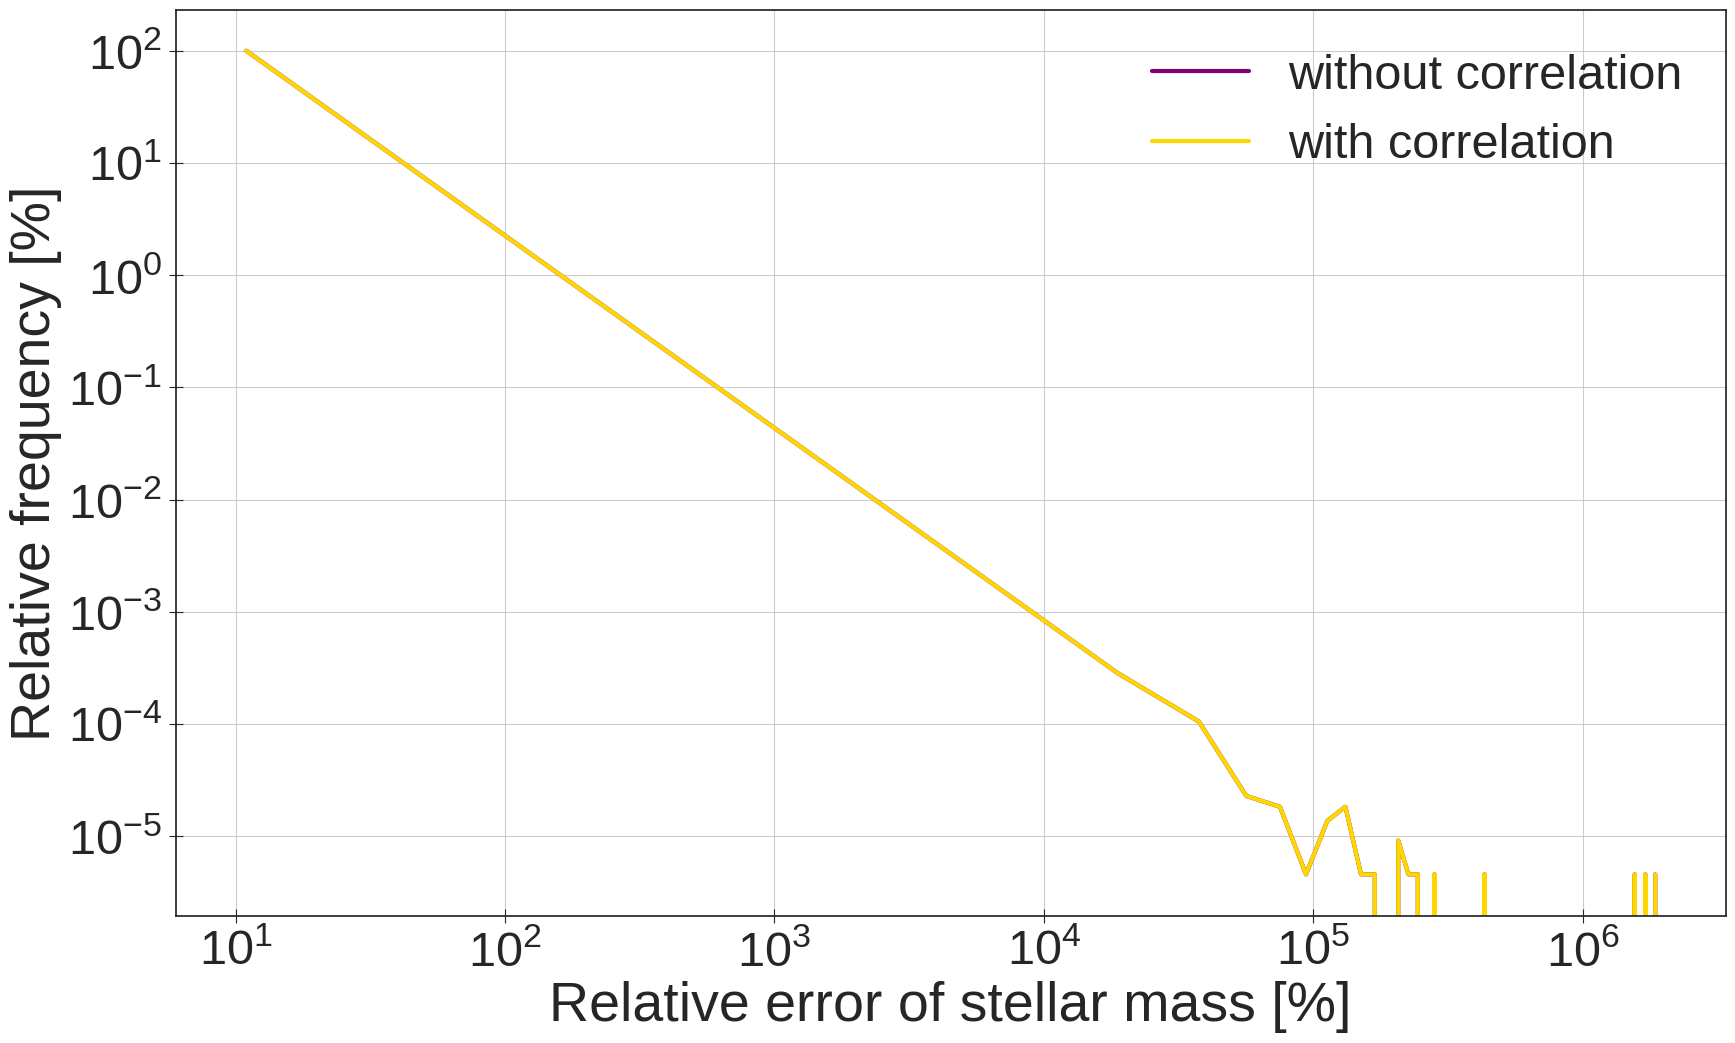

In [13]:
comp_hist( rel_err_M_Kettlety, rel_corr_err_M_Kettlety )

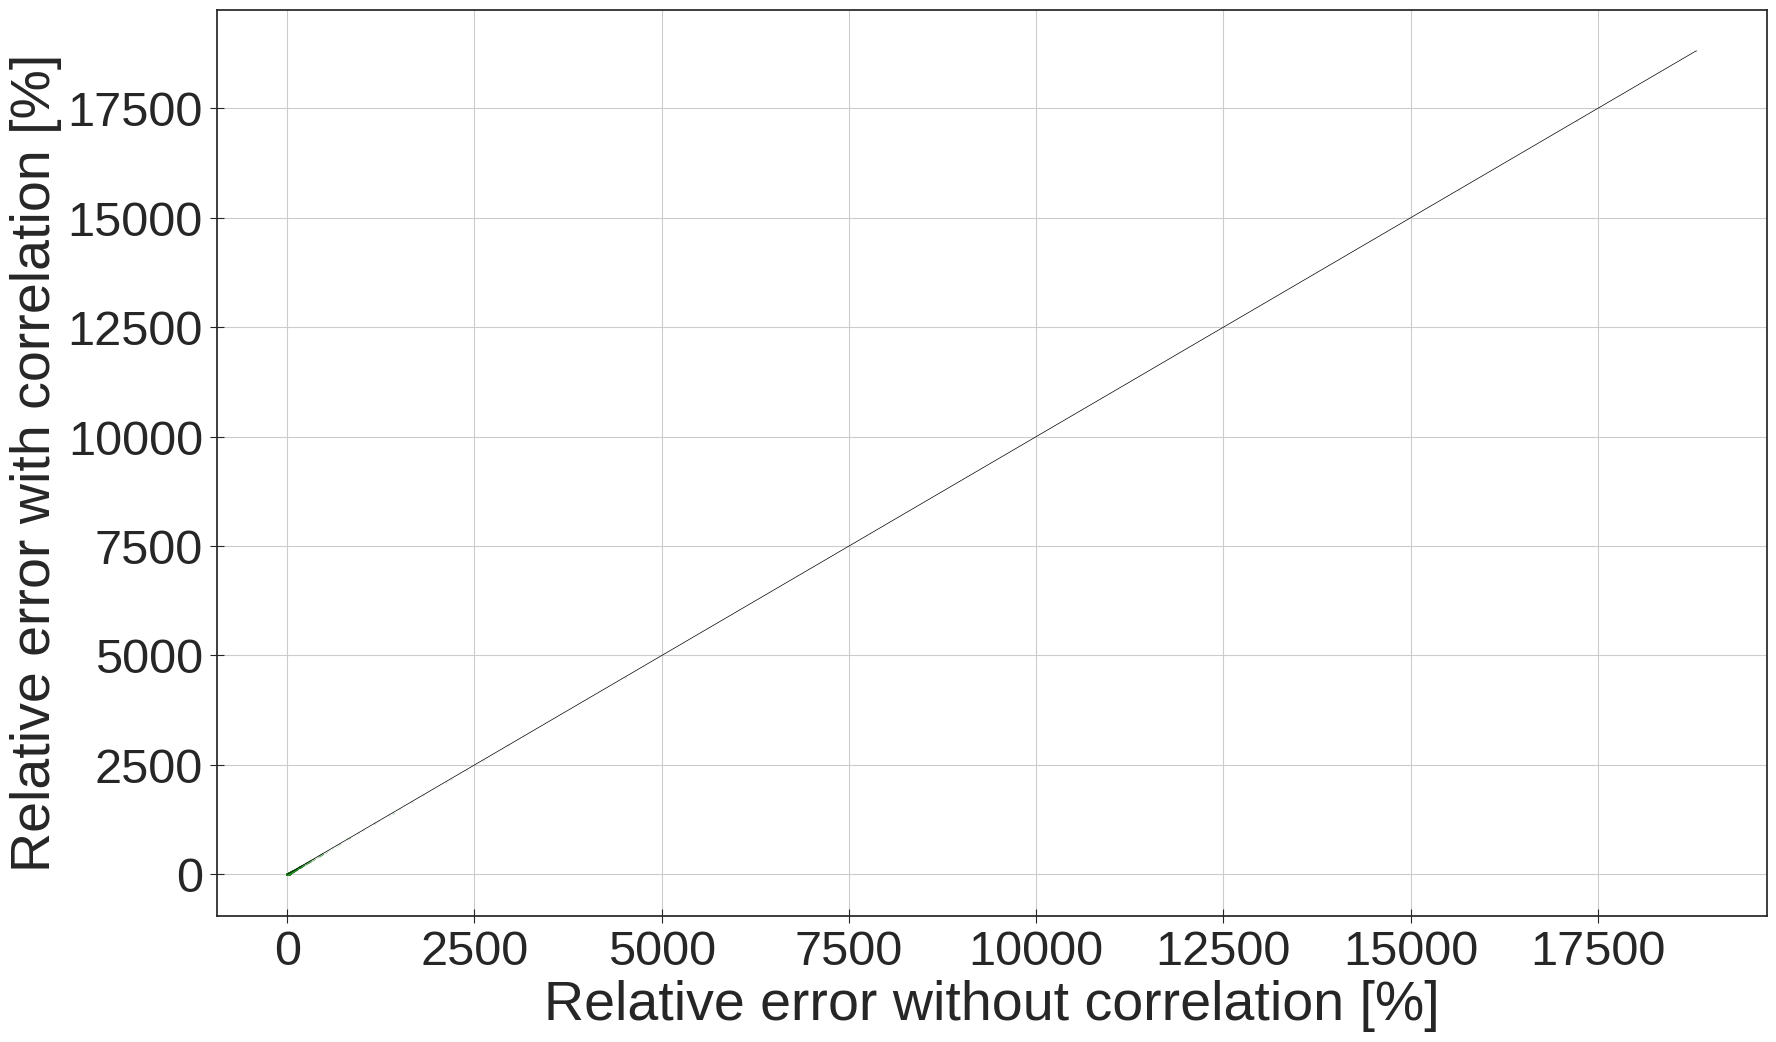

In [14]:
comp_plot( rel_err_M_Kettlety, rel_corr_err_M_Kettlety )

**Rounding the errors:**

In [15]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

# finding the order of the errors:
order_of_err_var = np.array([ orderOfMagnitude(i) for i in Kettlety_err ])
order_of_err_covar = np.array([orderOfMagnitude(i) for i in Kettlety_err_corr ])

# Rounding:
var_err_round = np.array( np.round( Kettlety_err / 10**order_of_err_var ) ) 
covar_err_round = np.array( np.round( Kettlety_err_corr / 10**order_of_err_covar ) ) 

print('Changing in magnitudes of the error:')
print( 'increases: ', (order_of_err_var - order_of_err_covar  == -1).sum(),
       '\ndoes not change: ', (order_of_err_var - order_of_err_covar  == 0).sum(),
       '\ndecreases: ', (order_of_err_var - order_of_err_covar  == 1).sum() )
print( '\nThe percentage of the changes in magnitude:')
print( ( order_of_err_var - order_of_err_covar != 0 ).sum()*100 / len(order_of_err_covar) )

Changing in magnitudes of the error:
increases:  0 
does not change:  20407783 
decreases:  1375145

The percentage of the changes in magnitude:
6.3129483786569


6.31% of the errors differs in magnitudes.

In [16]:
diff = np.abs( var_err_round*10**order_of_err_var-covar_err_round*10**order_of_err_covar )
uniq = np.unique( diff )

number = np.zeros(len(uniq))
for i in range( len( uniq ) ):
    number[i] = ( ( diff == uniq[i]).sum() )

In [17]:
number[uniq == 0]/len(M_Kettlety)*100

array([32.86506754])

32.87% of the errors does not differ.

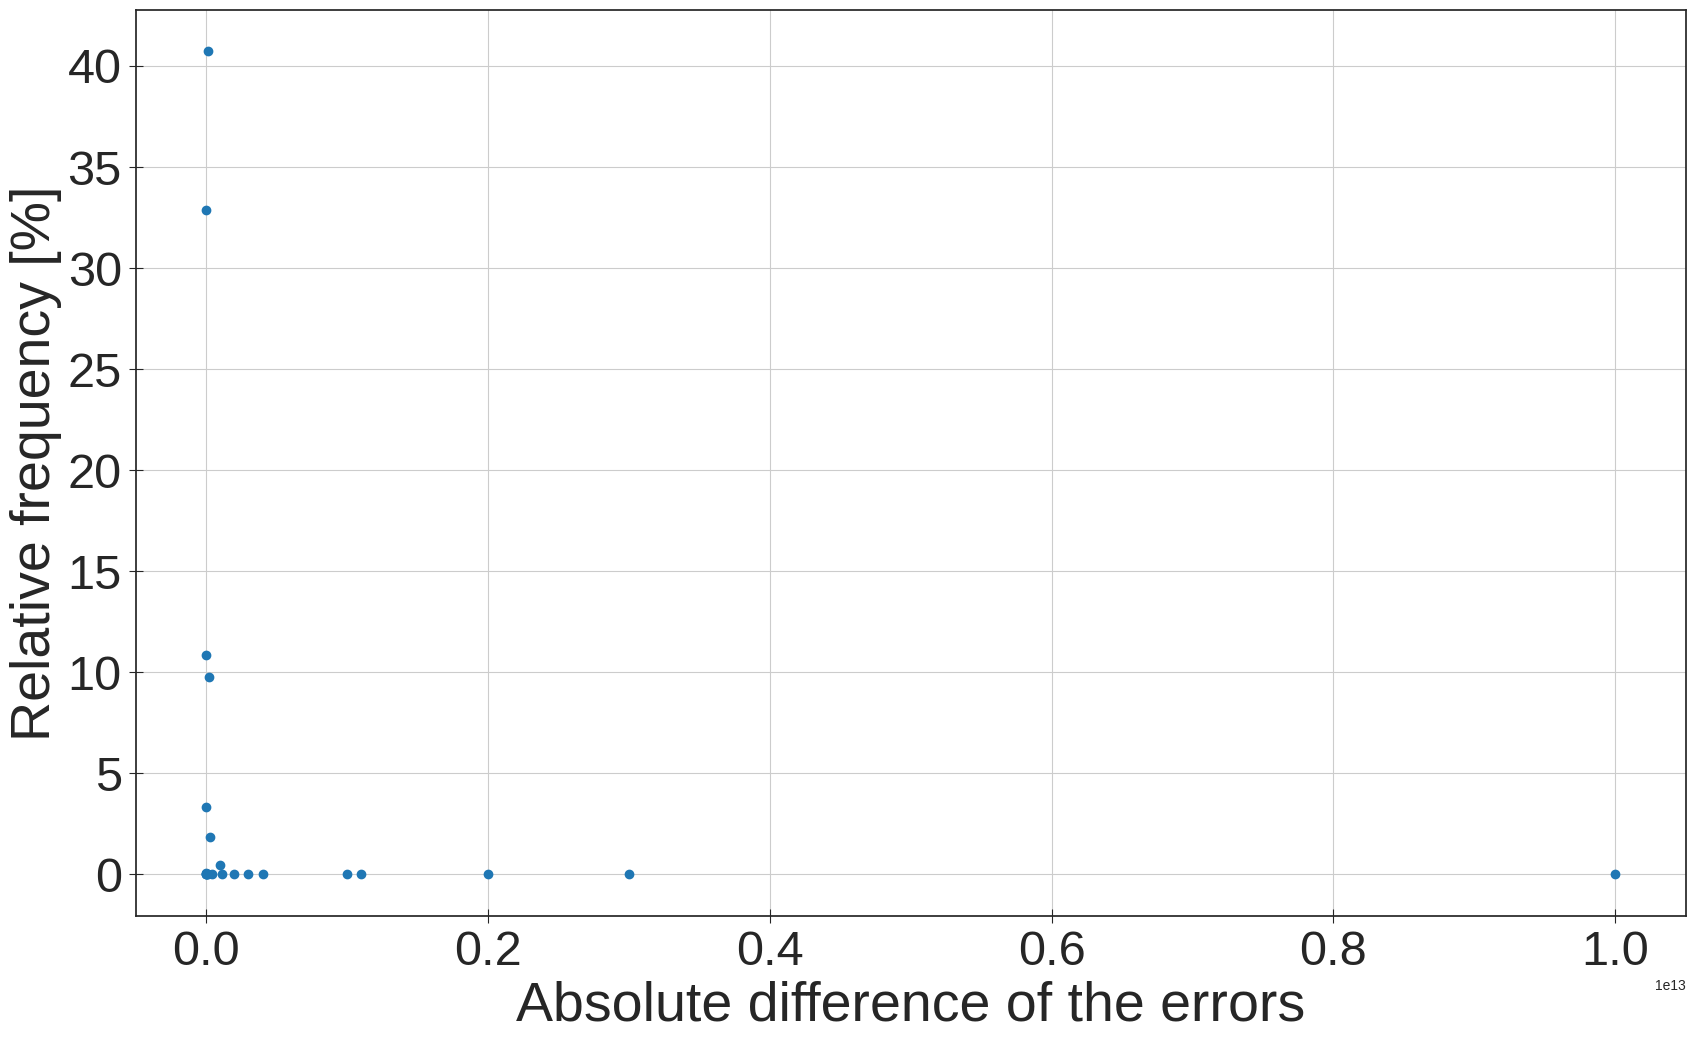

In [18]:
fig, ax = plt.subplots(figsize = (20, 12), dpi = 100)
plt.xlabel( 'Absolute difference of the errors', fontsize = 40 )
plt.ylabel( 'Relative frequency [%]', fontsize = 40 )
plt.tick_params( length=10, direction = 'inout', pad = 5 )
plt.xticks(fontsize = 35 )
plt.yticks( fontsize = 35 )
plt.scatter( uniq, number*100 / len(M_Kettlety) )
plt.grid()